##**Importing Libraries**

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Flatten,Bidirectional, Dense, Dropout, Reshape, GRU
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

##**Importing Dataset and Annotations**

In [2]:
path_gambar      = '/content/drive/MyDrive/DETEKSI-HELM/Model 1/Dataset-JPG'
gambar           = [*os.listdir('/content/drive/MyDrive/DETEKSI-HELM/Model 1/Dataset-JPG')]
anotasi          = '/content/drive/MyDrive/DETEKSI-HELM/Model 1/Dataset-XML'
output_data_path = '.'

##**Parsing Annotatons XML**

In [3]:
import xml.etree.ElementTree as ET
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects] 
    #Print(Constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   
  
def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)

    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

##**Return File Paths**

In [4]:
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(anotasi+"/*.xml") ]

#Since The output of the parse_annotation function is a list of lists, we need to flatten the ctopped faces.
full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)
df.shape

(299, 9)

In [5]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,BikesHelmets167,331,331,3,helm,115,3,179,62
1,BikesHelmets139,200,200,3,helm,82,22,127,65
2,BikesHelmets182,225,225,3,helm,91,5,155,78
3,BikesHelmets170,266,266,3,no_helm,69,5,114,54
4,BikesHelmets101,224,224,3,helm,98,3,137,42


##**Distribution of Label**

In [6]:
df["name"].value_counts()

helm       155
no_helm    144
Name: name, dtype: int64

Text(0, 0.5, 'Label')

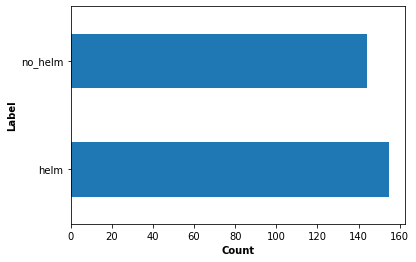

In [7]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Label', fontsize = 10, fontweight = 'bold')

##**Split Image into Train, Test and Val**

In [8]:
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)

##**Crop Image into Cropped Face**

In [9]:
from PIL import Image
def crop_img(image_path, x_min, y_min, x_max, y_max):
    #menambahkan pergeseran 10% dari ukuran potongan gambar yang diinginkan (x_shift dan y_shift)
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [10]:
#mengekstrak wajah-wajah dari gambar 
def extract_faces(image_name, image_info):

    faces = []
    #mengambil isian tabel yang berisi informasi tentang wajah-wajah yang muncul dalam gambar 
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, name = df_one_img.iloc[row_num] 
        image_path = os.path.join(path_gambar, image_name)
        #mengambil potongan gambar yang merupakan wajah, menambahkan informasi wajah dan koordinat wajah ke dalam list "faces" 
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), name,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces   

In [11]:
#membuat list yang berisi wajah-wajah yang diambil dari setiap gambar dan menyimpan list ini dalam variable "cropped_faces".
cropped_faces = [extract_faces(img, df) for img in gambar]

In [12]:
#menjumlahkan list-list dari "cropped_faces" dan menyatukannya ke dalam satu list yang disimpan dalam "flat_cropped_faces"
flat_cropped_faces = sum(cropped_faces, [])

In [13]:
#memisahkan wajah-wajah yang diambil dari "flat_cropped_faces" yang memiliki nama "helm" atau "no_helm" ke dalam list yang berbeda
helm = [(img, image_name) for img, name,image_name in flat_cropped_faces if name == "helm"]
no_helm = [(img, image_name) for img, name,image_name in flat_cropped_faces if name == "no_helm"]

In [14]:
#menghitung jumlah wajah sesuai label
print(f'Jumlah wajah yang menggunakan helm       :{len(helm)}')
print(f'Jumlah wajah yang tidak menggunakan helm :{len(no_helm)}')
print(f'Jumlah keseluruhan wajah                 :{len(helm) + len(no_helm)}')

Jumlah wajah yang menggunakan helm       :155
Jumlah wajah yang tidak menggunakan helm :144
Jumlah keseluruhan wajah                 :299


##**Add Cropped Image into Subfolder Train, Test, Val**

In [15]:
#membagi data dari list "helm" dan "no_helm" ke dalam 4 bagian yang berbeda
train_with_helm, test_with_helm = train_test_split(helm, test_size=0.20, random_state=1)
test_with_helm, val_with_helm = train_test_split(test_with_helm, test_size=0.7, random_state=1)

train_no_helm, test_no_helm = train_test_split(no_helm, test_size=0.20, random_state=1)
test_no_helm, val_no_helm = train_test_split(test_no_helm, test_size=0.7, random_state=1)

In [16]:
#menyimpan sebuah gambar ke dalam lokasi yang ditentukan dengan nama file yang ditentukan dalam subfolder 
def save_image(image, image_name, output_data_path,  dataset_type, name):
    output_path = os.path.join(output_data_path, dataset_type, name ,f'{image_name}.jpg')
    image.save(output_path)  

In [17]:
#menyimpan wajah yang diambil dari 'flat_cropped_faces' kedalam masing-masing folder
for image, image_name in train_with_helm:
    save_image(image, image_name, output_data_path, 'train', 'helm')

for image, image_name in train_no_helm:
    save_image(image, image_name, output_data_path, 'train', 'no_helm')

for image, image_name in test_with_helm:
    save_image(image, image_name, output_data_path, 'test', 'helm')

for image, image_name in test_no_helm:
    save_image(image, image_name, output_data_path, 'test', 'no_helm')

for image, image_name in val_with_helm:
    save_image(image, image_name, output_data_path, 'val', 'helm')

for image, image_name in val_no_helm:
    save_image(image, image_name, output_data_path, 'val', 'no_helm')

##**Create Model**

In [18]:
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (128,128,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dense(128, activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(
    optimizer="adam",
    loss="mse", metrics =['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

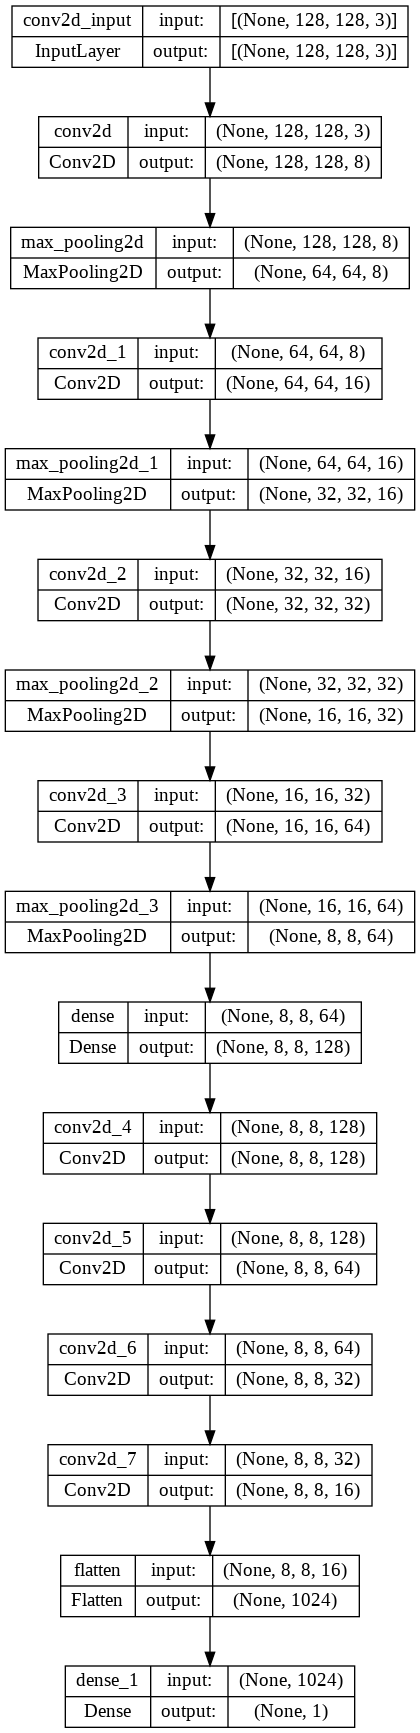

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

##**Image Generator**

In [19]:
batch_size = 1
epochs = 100

#membuat data generator yang dapat digunakan untuk melakukan preprocessing pada data gambar sebelum digunakan dalam proses pelatihan model
datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

# Train data 
train_generator = datagen.flow_from_directory(
    directory='/content/train', 
    target_size = (128, 128),
    class_mode="binary", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='/content/val', 
    target_size = (128, 128),
    class_mode="binary", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='/content/test', 
    target_size = (128, 128),
    class_mode="binary", batch_size=batch_size, shuffle=False
)

Found 239 images belonging to 2 classes.
Found 43 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


In [20]:
data_size = len(train_generator)

#menentukan jumlah data yang digunakan dalam satu epoch (iterasi) dari proses pelatihan dan validasi
steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 239
val_steps: 43


##**Training Model**

In [ ]:
#melatih model dengan menggunakan generator "train_generator" dan "val_generator" yang didefinisikan sebelumnya dengan parameter yang ditentukan
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps
)

Epoch 1/100


<ipython-input-22-9c5813b01eb7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


239/239 [==============================] - 13s 11ms/step - loss: 0.2528 - accuracy: 0.4561 - val_loss: 0.2497 - val_accuracy: 0.6047
Epoch 2/100
239/239 [==============================] - 2s 10ms/step - loss: 0.2505 - accuracy: 0.5523 - val_loss: 0.2498 - val_accuracy: 0.5116
Epoch 3/100
239/239 [==============================] - 2s 10ms/step - loss: 0.2503 - accuracy: 0.4770 - val_loss: 0.2499 - val_accuracy: 0.5116
Epoch 4/100
239/239 [==============================] - 2s 10ms/step - loss: 0.2519 - accuracy: 0.4979 - val_loss: 0.2500 - val_accuracy: 0.5116
Epoch 5/100
239/239 [==============================] - 2s 10ms/step - loss: 0.2480 - accuracy: 0.5063 - val_loss: 0.2584 - val_accuracy: 0.6047
Epoch 6/100
239/239 [==============================] - 2s 10ms/step - loss: 0.2547 - accuracy: 0.5021 - val_loss: 0.2508 - val_accuracy: 0.5116
Epoch 7/100
239/239 [==============================] - 2s 10ms/step - loss: 0.2566 - accuracy: 0.5356 - val_loss: 0.2448 - val_accuracy: 0.7209
Epo

##**Visualize from Model Training**

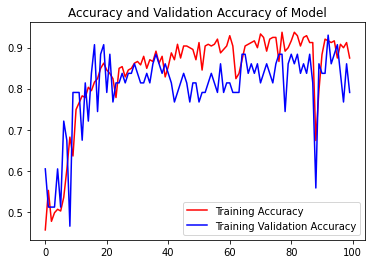

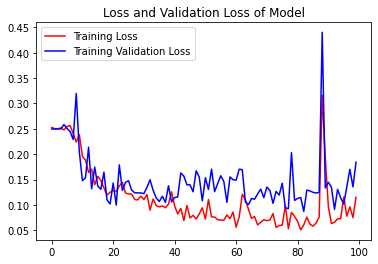

In [ ]:
%matplotlib inline
import matplotlib.image as mpig
import matplotlib.pyplot as plt

loss         = model_history.history['loss']
val_loss     = model_history.history['val_loss']
accuracy     = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label = "Training Accuracy")
plt.plot(epochs, val_accuracy, 'b', label = "Training Validation Accuracy")
plt.title("Accuracy and Validation Accuracy of Model")
plt.legend(loc = 'best')
plt.show()
print()
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Training Validation Loss")
plt.title("Loss and Validation Loss of Model")
plt.legend(loc = 'best')
plt.show()

##**Save Model**

In [ ]:
model.save_weights('Kipas_Angin_Fungsi_2_fix.h5')

##**Practice**

In [21]:
model.load_weights('/content/drive/MyDrive/DETEKSI-HELM/Kipas_Angin_Fungsi_2_fix.h5')

In [22]:
y_pred = model.predict(test_generator)
y_pred

17/17 [==============================] - 1s 12ms/step


array([[6.2607748e-13],
       [1.0494559e-10],
       [6.4481054e-03],
       [1.6157202e-10],
       [1.1562278e-05],
       [1.9303825e-31],
       [1.0967191e-06],
       [0.0000000e+00],
       [9.9783306e-21],
       [3.1216019e-05],
       [9.9999553e-01],
       [9.9997729e-01],
       [9.9998623e-01],
       [3.9788010e-04],
       [2.1934979e-19],
       [2.9763682e-02],
       [9.9997407e-01]], dtype=float32)

In [23]:
y_pred = model.predict(test_generator)
y_pred = (y_pred>0.5)*1
y_pred

17/17 [==============================] - 0s 11ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1]])

17/17 [==============================] - 0s 12ms/step
helm || no_helm


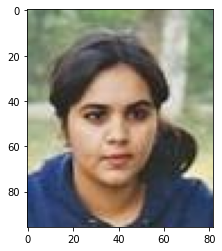

In [24]:
paths = test_generator.filenames
y_pred = model.predict(test_generator)
y_pred = (y_pred>0.5)*1
y_pred = y_pred.reshape(-1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

17/17 [==============================] - 0s 11ms/step
helm || helm


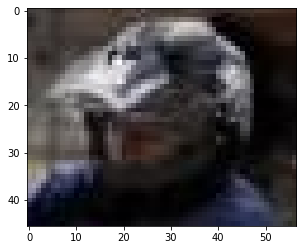

In [25]:
paths = test_generator.filenames
y_pred = model.predict(test_generator)
y_pred = (y_pred>0.5)*1
y_pred = y_pred.reshape(-1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

17/17 [==============================] - 0s 11ms/step
helm || helm


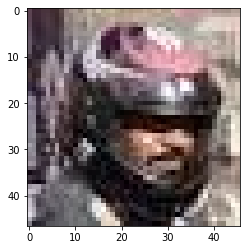

In [27]:
paths = test_generator.filenames
y_pred = model.predict(test_generator)
y_pred = (y_pred>0.5)*1
y_pred = y_pred.reshape(-1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')
